In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

import joblib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scripts import utils
VECTORIZER_PATH = utils.get_datapath('vectorizer_data')

%load_ext autoreload
%autoreload 2

# **Spotify Popularity Classification**

## Predicting Popularity Using Logistic Regression and Bag of Words

We will try to use logistic regression with default parameters to predict whether a song will be popular or not.
This prediction will utilize a bag of words representation of the lyrics.

In [28]:
X_train, X_test, y_train, y_test = utils.load_transformed_data('bag_of_words_two_class')

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30324, 2217), (7581, 2217), (30324,), (7581,))

In [32]:
type(X_train), type(X_test), type(y_train), type(y_test)

(scipy.sparse._csr.csr_matrix,
 scipy.sparse._csr.csr_matrix,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [38]:

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)


/home/jng/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [39]:
print(log_reg.score(X_train, y_train))

0.66798575385833


We can see that this model did not converge and was unable to minimize the cost function. This explains its poor performance for the training data. The default solver `lbfgs` might not be suitable for this dataset. 

We will try the `newton-cholesky` solver as the number of samples is much larger than the number of features.

In [44]:
log_reg = LogisticRegression(solver='newton-cg')
log_reg.fit(X_train, y_train)
print(f'Train Accuracy: {log_reg.score(X_train, y_train)}')

Train Accuracy: 0.6662709405091677


In [45]:
print(f'Test Accuracy: {log_reg.score(X_test, y_test)}')

Test Accuracy: 0.5964912280701754


This solver lets the model converge and provides a test accuracy of 66.6% and a train accuracy of 59.6%

We will try to improve this model by using L2 regularization. This is the only regularization that works with the `newton-cholesky` solver. Additionally we will try various C values to see how the accuracy changes.

In [49]:
c_range = [
    (1/10)**n
    for n in np.arange(0,10,0.5)
]

train_accuracy = []
test_accuracy = []

for c in c_range:
    log_reg = LogisticRegression(penalty='l2', C=c, solver='newton-cg')
    log_reg.fit(X_train, y_train)
    train_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))



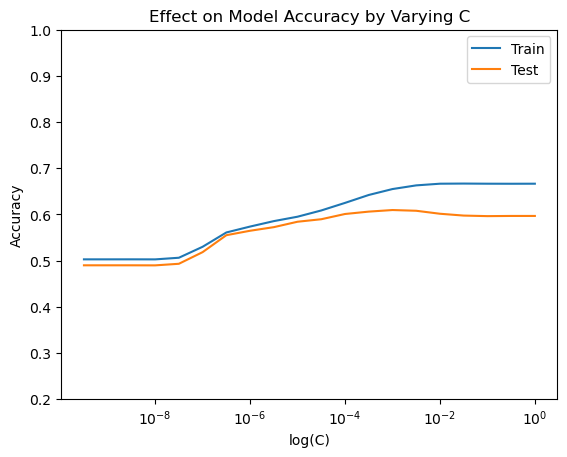

In [52]:
plt.figure()
plt.title('Effect on Model Accuracy by Varying C')
plt.plot(c_range, train_accuracy, label='Train')
plt.plot(c_range, test_accuracy, label='Test')
plt.xscale('log')
plt.xlabel('log(C)')
plt.ylabel('Accuracy')
plt.ylim(0.2,1)
plt.legend()
plt.show()

In [56]:
print(f'Max Accuracy: {test_accuracy[np.argmax(test_accuracy)]}')
print(f'C: {c_range[np.argmax(test_accuracy)]}')

Max Accuracy: 0.6092863738293102
C: 0.0010000000000000002


We see that we get a peak test accuracy of approximately 60.9% with our logistic regression where we used an l2 regularization with an $\alpha = 1000$ 

This is a slight improvement over our initial model, where no regularization was used.